# RNN USE
I denne notebooken tar jeg i bruk den modellen jeg har lagd tidligere

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens
from lib.create_dataset import create_dataset
from lib.evaluate_trade import evaluate_trades
from lib.make_ready import make_ready

In [17]:

def evaluate_trade(data, df_pred, prediciton, look_forward):
    
    # Trenger på en eller annen måte å finne ut hvilke kjøp/selg paramtere som er gode
    best_param = pd.DataFrame(columns=['start', 'stopp', 'lengde', 'pred_start', 'pred_stopp',
                                       'ac_sum', 'start_pris', 'stopp_pris', 'prosent_gevinst'])
    best_start = []
    best_stopp = []
    best_lengde = []
    best_pred_start = []
    best_pred_stopp = []
    best_ac_sum = []
    best_start_pris = []
    best_stopp_pris = []
    best_prosent_gevinst = []
    # Dropper de første 32 fra data
    best_data = data.copy()
    best_data = best_data.iloc[32:]
    
    print(best_data.shape, df_pred.shape)
    
    
    ac_sum_2 = 0
    for i, pred in enumerate(df_pred.avg):
        
        # for hvert trinn frem
        for j in range(i, len(df_pred.avg)):
            best_start.append(i)
            best_stopp.append(j)
            best_lengde.append(j-i)
            
            best_pred_start.append(df_pred.avg[i])
            best_pred_stopp.append(df_pred.avg[j])
            
            best_start_pris.append(data.open[i])
            best_stopp_pris.append(data.open[j])
            best_prosent_gevinst.append(data.open[j]/data.open[i])
    
    best_param['start'] = best_start
    best_param['stopp'] = best_stopp
    best_param['lengde'] = best_lengde
    best_param['pred_start'] = best_pred_start
    best_param['pred_stopp'] = best_pred_stopp
    best_param['start_pris'] = best_start_pris
    best_param['stopp_pris'] = best_stopp_pris
    best_param['prosent_gevinst'] = best_prosent_gevinst
    
    best_param = best_param.sort_values(by=['prosent_gevinst'], ascending=False)
    best_param = best_param[best_param.lengde > 10]
    best_param = best_param[best_param.lengde < 60]
    #print(best_param.head(15))
    #plt.plot(best_data.open)
    #plt.show()
            
            
    #    if ix > 32:
    #        for j in 

    #return 0
    
    
    fig, ax1 = plt.subplots()
    #for i,v in enumerate(prediciton):
    #    ax1.plot(range(i+30, i+30+len(v)), v, color='red')
        
    p1, = ax1.plot(range(30, len(df_pred.avg)+30), df_pred.avg, color='red', label='avg_pred')
    ax1.set_ylabel('30sma_prediction')
    ax1.yaxis.label.set_color('red')
    
    ax2 = ax1.twinx()
    p2, = ax2.plot(data.open, color='blue', label='true_price')
    ax2.set_ylabel('True price')
    ax2.yaxis.label.set_color('blue')
    
    # If df_pred.avg is big enough then buy
    forslag = ['0_selg']*21
    bytteix = pd.DataFrame(columns=['kjøp', 'selg', 'pris_kjøp', 'pris_salg', 'gevinst','ac_sum'])
    bytteix_buy = []
    bytteix_sell = []
    bytteswitch = True
    bytte_ac_sum = []
    ac_sum = 0
    for ix,pred in enumerate(df_pred.avg):
        if ix>0:
            
            # Kjøp og salg
            if pred>0.3:
                ac_sum += pred
            else:
                ac_sum = 0

            if pred > 0.75:
                forslag.append('1_kjøp')
                if bytteswitch:
                    bytte_ac_sum.append(ac_sum)
                    bytteix_buy.append(ix+20)
                    bytteswitch = False

            else:
                forslag.append('0_selg')
                if not bytteswitch:
                    bytteix_sell.append(ix+20)
                    bytteswitch = True
            
            
    
    bytteix.kjøp = bytteix_buy
    bytteix.selg = bytteix_sell
    bytteix.ac_sum = bytte_ac_sum
    
    gevinst = []
    pris_kjøp = []
    pris_salg = []
    for i, row in bytteix.iterrows():
        buy = data.open[row.kjøp]
        sell = data.open[row.selg]
        gevinst.append(sell/buy)
        pris_kjøp.append(data.open[row.kjøp])
        pris_salg.append(data.open[row.selg])
    
    bytteix.gevinst = gevinst
    bytteix.pris_kjøp = pris_kjøp
    bytteix.pris_salg = pris_salg
        
    
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    p3, = ax3.plot(forslag, color='green')
    ax3.set_ylabel('forslag axes')
    ax3.yaxis.label.set_color('green')
    
    lines = [p1, p2]
    plt.legend(lines, [l.get_label() for l in lines])
    
    plt.show()
    
    print(bytteix)
    return bytteix.gevinst
    

    
def add_data(word):
    ordet = 'data/' + word
    return ordet


In [3]:
filer = list(map(add_data, os.listdir('data/')))[24:30] # test 54:60
data = make_ready().use_stockstats(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [4]:
dataxes = []
datayes = []
sanne = []
look_back=30
look_forward=10

for one_stock in data:
    datax, datay, sann = create_dataset().create(
                                  one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                  one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
    dataxes.append(datax)
    datayes.append(datay)
    sanne.append(sann)

In [5]:
model = keras.models.load_model('models/rnn_model.h5')

(379, 23) (379, 3)


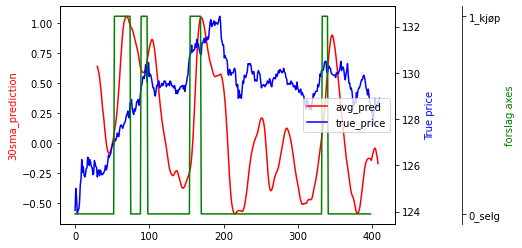

   kjøp  selg  pris_kjøp  pris_salg   gevinst     ac_sum
0    53    75     127.15     128.65  1.011797   3.595271
1    89    98     129.40     130.05  1.005023  33.388333
2   155   170     130.80     130.80  1.000000   2.893063
3   333   341     130.10     130.25  1.001153   4.106642
(296, 23) (296, 3)


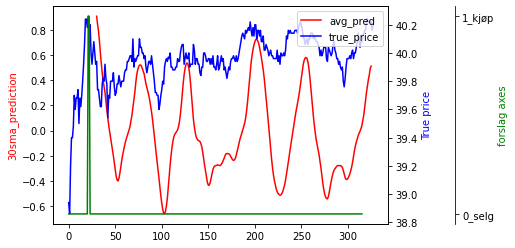

   kjøp  selg  pris_kjøp  pris_salg  gevinst    ac_sum
0    21    23      40.26       40.2  0.99851  0.845216
(374, 23) (374, 3)


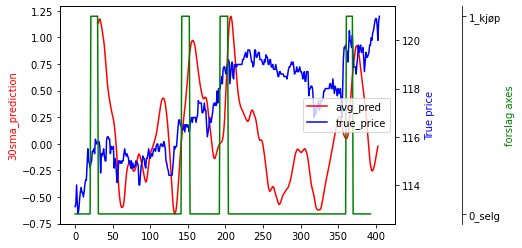

   kjøp  selg  pris_kjøp  pris_salg   gevinst    ac_sum
0    21    31      114.9      115.8  1.007833  1.133186
1   142   153      116.3      116.5  1.001720  3.950281
2   193   204      118.0      119.2  1.010169  2.484373
3   361   370      119.6      119.2  0.996656  3.446791
(332, 23) (332, 3)


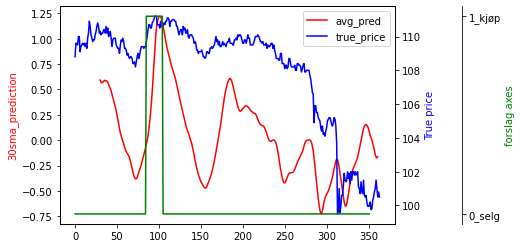

   kjøp  selg  pris_kjøp  pris_salg   gevinst    ac_sum
0    85   105      109.7      110.7  1.009116  3.084627
(246, 23) (246, 3)


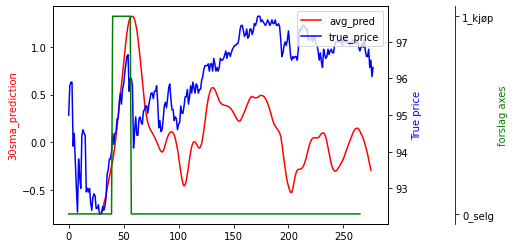

   kjøp  selg  pris_kjøp  pris_salg   gevinst   ac_sum
0    40    57       94.5       96.0  1.015873  3.03303
(371, 23) (371, 3)


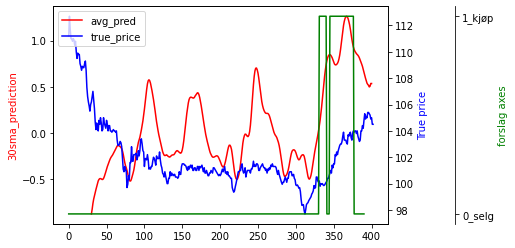

   kjøp  selg  pris_kjøp  pris_salg   gevinst     ac_sum
0   331   341      100.2      100.2  1.000000   4.178211
1   345   377      100.8      103.9  1.030754  15.295652
[100]


In [18]:
cash = [100]
for i,stockdata in enumerate(data):
    prediciton = model.predict(dataxes[i])
    df_pred = evaluate_trades().prepare_evaluate_trade(prediciton)
    gevinst = evaluate_trade(stockdata, df_pred, prediciton, look_forward)
    #for j in gevinst:
    #    cash.append(cash[-1]*j)
        
print(cash)

In [333]:
df_pred

,tid,verdier,avg
0,0,[1.0],1.000000
1,1,"[1.0, -0.03304274]",0.483479
2,2,"[1.0, -0.077676564, -0.070980646]",0.283781
3,3,"[1.0, -0.053049, -0.11929916, -0.09770004]",0.182488
4,4,"[1.0, -0.070169635, -0.10113522, -0.14998336, ...",0.118277
...,...,...,...
325,325,"[0.0002685776, -0.059146624, -0.048997708, 0.0...",-0.004114
326,326,"[0.019175678, -0.03193757, 0.020856429, 0.0873...",0.023867
327,327,"[0.043075617, 0.041563805, 0.08628017]",0.056973
328,328,"[0.113419764, 0.113912866]",0.113666


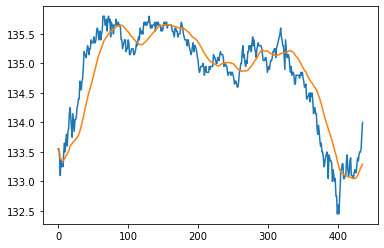

In [69]:
plt.plot(data[0].open)
plt.plot(data[0].open_30_sma)

In [143]:
data[0]

,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_15_sma,sma8-16,sma30_derivert,sma15_derivert,derivert
0,9:0,133.55,133.55,133.55,133.55,77319,77319,NaN,NaN,NaN,...,133.550000,0.000000,0.000000,0.000000,133.550000,133.550000,0.000000,1.000000,1.000000,1.000000
1,9:1,133.55,133.55,133.55,133.55,13845,13845,133.55,0.00,NaN,...,133.550000,0.000000,0.000000,0.000000,133.550000,133.550000,0.000000,1.000000,1.000000,1.000000
2,9:2,133.40,133.40,133.40,133.40,29772,29772,133.55,-0.15,0.000000,...,133.500000,-0.004651,-0.001906,-0.002745,133.500000,133.500000,0.000000,0.999626,0.999626,0.998877
3,9:3,133.10,133.10,133.10,133.10,14807,14807,133.40,-0.30,0.000000,...,133.400000,-0.017484,-0.007183,-0.010301,133.400000,133.400000,0.000000,0.999251,0.999251,0.997751
4,9:4,133.35,133.35,133.35,133.35,13958,13958,133.10,0.25,0.594707,...,133.390000,-0.014142,-0.009253,-0.004888,133.390000,133.390000,0.000000,0.999925,0.999925,1.001878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,16:16,133.50,133.50,133.50,133.50,12738,12738,133.45,0.05,1.274000,...,133.243750,0.060187,0.021415,0.038772,133.195000,133.250000,0.068750,1.000263,1.000175,1.000375
432,16:17,133.50,133.50,133.50,133.50,33641,33641,133.50,0.00,1.274000,...,133.265625,0.071448,0.031421,0.040027,133.223333,133.260000,0.084375,1.000213,1.000075,1.000000
433,16:18,133.55,133.55,133.55,133.55,12709,12709,133.50,0.05,1.336942,...,133.278125,0.083446,0.041826,0.041619,133.245000,133.270000,0.121875,1.000163,1.000075,1.000375
434,16:19,133.80,133.80,133.80,133.80,17495,17495,133.55,0.25,1.668213,...,133.303125,0.111837,0.055828,0.056009,133.265000,133.316667,0.178125,1.000150,1.000350,1.001872


In [20]:
a = 0
for i in range(400,1,-1):
    a += i
    
a

80199